# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/vision/stable/transforms.html)

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/home/xpz1/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


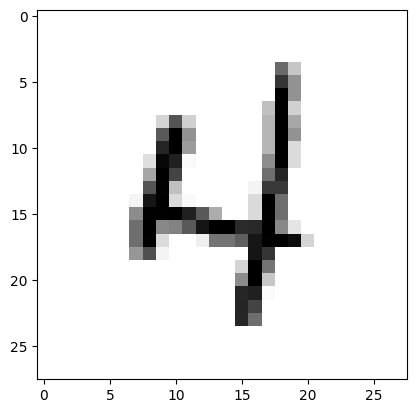

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

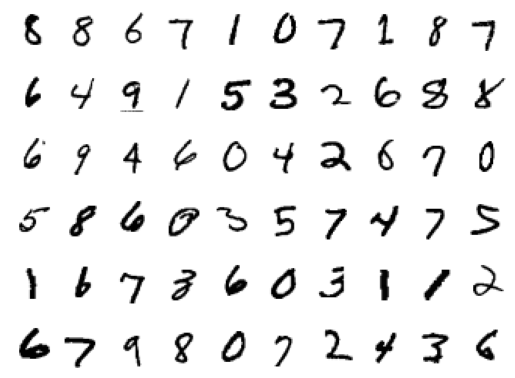

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/home/xpz1/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# The model
Let's start with the model we first saw

In [13]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # 28x28x1 > 28x28x16 | 3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 28x28x16 > 28x28x32 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28x28x32 > 14x14x32 | 10  
        self.conv3 = nn.Conv2d(32, 32, 3) # 14x14x32 > 12x12x32 | 12
        self.conv4 = nn.Conv2d(32, 32, 3) # 12x12x32 > 10x105x32 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 10x10x32 > 5x5x32 | 28
        self.conv5 = nn.Conv2d(32, 16, 3) # 5x5x32 > 3x3x16 | 30
        self.conv6 = nn.Conv2d(16, 10, 3) # 3x3x16 > 1x1x10 | 30
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 28, 28]           4,640
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           9,248
            Conv2d-5           [-1, 32, 10, 10]           9,248
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 16, 3, 3]           4,624
            Conv2d-8             [-1, 10, 1, 1]           1,450
Total params: 29,370
Trainable params: 29,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.40
Params size (MB): 0.11
Estimated Total Size (MB): 0.52
----------------------------------------------------------------


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [16]:
model =  Net_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.7789626717567444 Batch_id=468 Accuracy=57.93: 100%|██████████| 469/469 [00:02<00:00, 204.34it/s] 



Test set: Average loss: 0.5280, Accuracy: 7907/10000 (79.07%)

EPOCH: 1


Loss=0.33379149436950684 Batch_id=468 Accuracy=85.92: 100%|██████████| 469/469 [00:02<00:00, 175.98it/s]



Test set: Average loss: 0.2883, Accuracy: 8853/10000 (88.53%)

EPOCH: 2


Loss=0.28807592391967773 Batch_id=468 Accuracy=88.81: 100%|██████████| 469/469 [00:01<00:00, 253.56it/s]



Test set: Average loss: 0.2701, Accuracy: 8903/10000 (89.03%)

EPOCH: 3


Loss=0.2656877040863037 Batch_id=468 Accuracy=89.11: 100%|██████████| 469/469 [00:02<00:00, 165.24it/s] 



Test set: Average loss: 0.2658, Accuracy: 8925/10000 (89.25%)

EPOCH: 4


Loss=0.15103855729103088 Batch_id=468 Accuracy=89.21: 100%|██████████| 469/469 [00:02<00:00, 173.10it/s]



Test set: Average loss: 0.2608, Accuracy: 8939/10000 (89.39%)

EPOCH: 5


Loss=0.2895576059818268 Batch_id=468 Accuracy=89.37: 100%|██████████| 469/469 [00:02<00:00, 164.34it/s] 



Test set: Average loss: 0.2578, Accuracy: 8942/10000 (89.42%)

EPOCH: 6


Loss=0.22898751497268677 Batch_id=468 Accuracy=89.50: 100%|██████████| 469/469 [00:02<00:00, 187.81it/s]



Test set: Average loss: 0.2624, Accuracy: 8939/10000 (89.39%)

EPOCH: 7


Loss=0.18287380039691925 Batch_id=468 Accuracy=89.56: 100%|██████████| 469/469 [00:02<00:00, 169.17it/s]



Test set: Average loss: 0.2602, Accuracy: 8924/10000 (89.24%)

EPOCH: 8


Loss=0.018702084198594093 Batch_id=468 Accuracy=93.50: 100%|██████████| 469/469 [00:02<00:00, 173.88it/s] 



Test set: Average loss: 0.0490, Accuracy: 9850/10000 (98.50%)

EPOCH: 9


Loss=0.0030583858024328947 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:02<00:00, 176.21it/s]



Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.004331985954195261 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:02<00:00, 171.33it/s]  



Test set: Average loss: 0.0332, Accuracy: 9881/10000 (98.81%)

EPOCH: 11


Loss=0.05126219987869263 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:02<00:00, 159.36it/s]  



Test set: Average loss: 0.0291, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.019474053755402565 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:02<00:00, 167.16it/s]  



Test set: Average loss: 0.0318, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.05583682283759117 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:02<00:00, 166.84it/s]   



Test set: Average loss: 0.0322, Accuracy: 9896/10000 (98.96%)

EPOCH: 14


Loss=0.01493969839066267 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:02<00:00, 165.11it/s]   



Test set: Average loss: 0.0319, Accuracy: 9892/10000 (98.92%)



In [16]:
train_losses

[tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3035, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3003, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2997, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2973, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2960, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2955, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2941, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2925, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2894, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2852, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2840, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2809, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [17]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

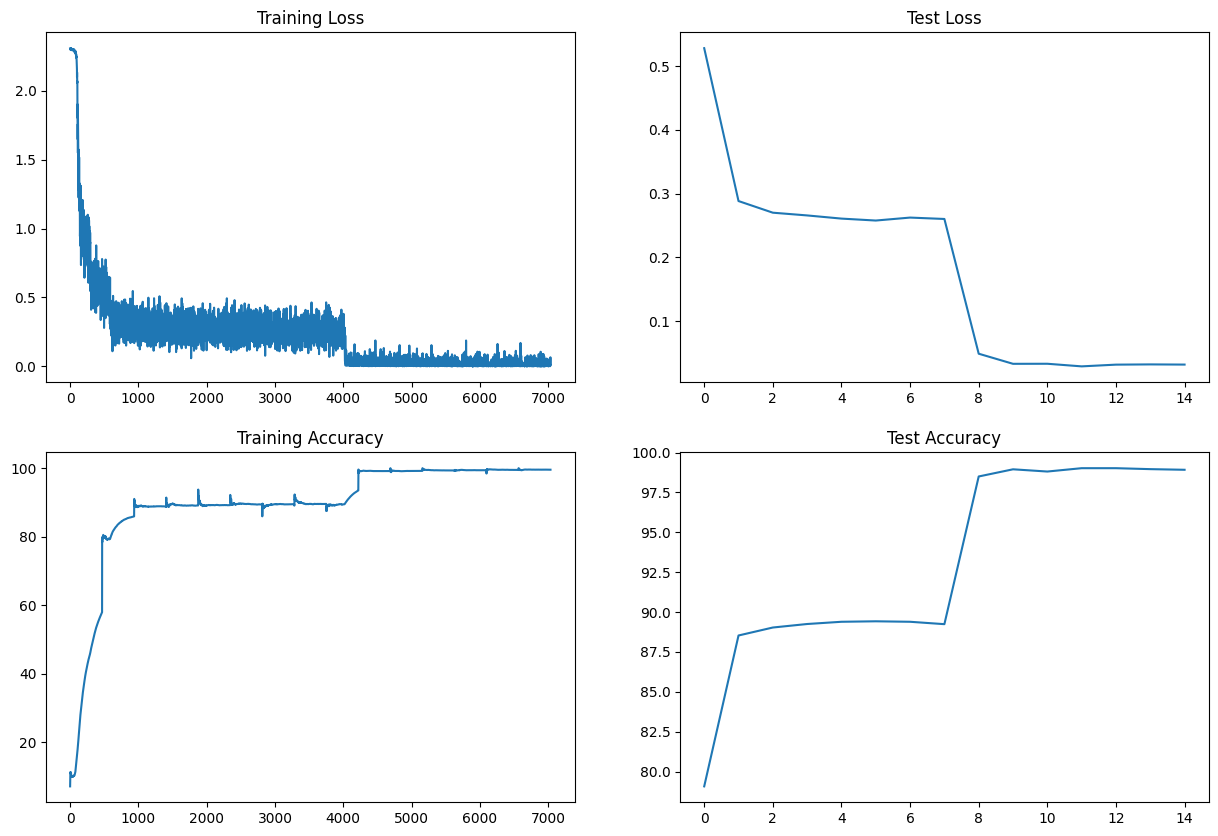

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")